In [1]:
from pathlib import Path
import duckdb
import pandas as pd
import numpy as np
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting style
plt.style.use('default')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)

# Domain-Topic Distribution Heatmaps

This notebook generates heatmaps showing the distribution of topics across the most prevalent domains for two datasets:
- **UCI Categories**: News articles with categories (b, e, m, t)
- **Recognasumm**: Brazilian news articles with Portuguese categories

The heatmaps show what percentage of articles from each domain fall under each topic category.

In [2]:
# Initialize DuckDB connection
con = duckdb.connect()

# Get paths to data files
ds_paths = list(Path("../data/raw").glob("*.parquet"))
print("Available datasets:", [p.name for p in ds_paths])

Available datasets: ['news_categories.parquet', 'recognasumm.parquet', 'uci_categories.parquet']


In [ ]:
def extract_domain(url):
    """Extract domain from URL, handling edge cases."""
    try:
        domain = urlparse(url).netloc
        return domain if domain else 'unknown'
    except Exception as e:
        print(f"Error extracting domain from URL '{url}': {e}")
        return 'unknown'

def create_domain_topic_heatmap(df, url_col, topic_col, title, top_domains=10, top_topics=10):
    """
    Create a heatmap showing the proportion of articles from each domain 
    that fall under each topic category.
    
    Parameters:
    - df: DataFrame with URL and topic columns
    - url_col: name of URL column
    - topic_col: name of topic/category column  
    - title: title for the plot
    - top_domains: number of top domains to include
    - top_topics: number of top topics to include
    
    Returns:
    - matplotlib figure
    """
    # Extract domains
    df_copy = df.copy()
    df_copy['domain'] = df_copy[url_col].apply(extract_domain)
    
    # Filter out unknown/empty domains
    df_copy = df_copy[df_copy['domain'] != 'unknown']
    df_copy = df_copy[df_copy['domain'] != '']
    
    # Get top domains by frequency
    top_domain_list = df_copy['domain'].value_counts().head(top_domains).index.tolist()
    
    # Get top topics by frequency  
    top_topic_list = df_copy[topic_col].value_counts().head(top_topics).index.tolist()
    
    # Filter data to top domains and topics
    filtered_df = df_copy[
        (df_copy['domain'].isin(top_domain_list)) & 
        (df_copy[topic_col].isin(top_topic_list))
    ]
    
    # Create cross-tabulation
    crosstab = pd.crosstab(filtered_df['domain'], filtered_df[topic_col])
    
    # Convert to percentages (each row sums to 100%)
    percentage_crosstab = crosstab.div(crosstab.sum(axis=1), axis=0) * 100
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create heatmap
    sns.heatmap(
        percentage_crosstab, 
        annot=True, 
        fmt='.1f', 
        cmap='YlOrRd',
        cbar_kws={'label': 'Percentage of domain articles (%)'},
        ax=ax
    )
    
    # Customize plot
    ax.set_title(f'{title}\nPercentage of articles from each domain by topic', 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Topic Category', fontsize=12, fontweight='bold')
    ax.set_ylabel('Domain', fontsize=12, fontweight='bold')
    
    # Rotate labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    
    plt.tight_layout()
    
    # Print summary statistics
    print(f"\n{title} Summary:")
    print(f"Total articles analyzed: {len(filtered_df):,}")
    print(f"Top {top_domains} domains: {top_domain_list}")
    print(f"Top {top_topics} topics: {top_topic_list}")
    print("\nDomain article counts:")
    domain_counts = filtered_df['domain'].value_counts()
    for domain in top_domain_list:
        print(f"  {domain}: {domain_counts[domain]:,} articles")
    
    return fig

## UCI Categories Dataset Analysis

The UCI dataset contains news articles with categories:
- **b**: Business
- **e**: Entertainment  
- **m**: Health/Medical
- **t**: Science/Technology

In [4]:
# Load UCI Categories dataset
uci_df = con.execute('SELECT * FROM read_parquet("../data/raw/uci_categories.parquet")').df()

print(f"UCI Dataset shape: {uci_df.shape}")
print("\nCategory distribution:")
print(uci_df['CATEGORY'].value_counts())

# Check for missing values
print("\nMissing values:")
print(uci_df[['URL', 'CATEGORY']].isnull().sum())

# Preview data
print("\nSample data:")
print(uci_df[['URL', 'CATEGORY', 'TITLE']].head())

UCI Dataset shape: (422419, 8)

Category distribution:
CATEGORY
e    152469
b    115967
t    108344
m     45639
Name: count, dtype: int64

Missing values:
URL         0
CATEGORY    0
dtype: int64

Sample data:
                                                 URL CATEGORY  \
0  http://www.latimes.com/business/money/la-fi-mo...        b   
1  http://www.livemint.com/Politics/H2EvwJSK2VE6O...        b   
2  http://www.ifamagazine.com/news/us-open-stocks...        b   
3  http://www.ifamagazine.com/news/fed-risks-fall...        b   
4  http://www.moneynews.com/Economy/federal-reser...        b   

                                               TITLE  
0  Fed official says weak data caused by weather,...  
1  Fed's Charles Plosser sees high bar for change...  
2  US open: Stocks fall after Fed official hints ...  
3  Fed risks falling 'behind the curve', Charles ...  
4  Fed's Plosser: Nasty Weather Has Curbed Job Gr...  



UCI Categories Dataset Summary:
Total articles analyzed: 22,575
Top 10 domains: ['in.reuters.com', 'www.huffingtonpost.com', 'www.businessweek.com', 'www.contactmusic.com', 'www.dailymail.co.uk', 'www.nasdaq.com', 'www.examiner.com', 'www.globalpost.com', 'www.latimes.com', 'www.bizjournals.com']
Top 10 topics: ['e', 'b', 't', 'm']

Domain article counts:
  in.reuters.com: 2,877 articles
  www.huffingtonpost.com: 2,603 articles
  www.businessweek.com: 2,420 articles
  www.contactmusic.com: 2,334 articles
  www.dailymail.co.uk: 2,258 articles
  www.nasdaq.com: 2,228 articles
  www.examiner.com: 2,085 articles
  www.globalpost.com: 1,975 articles
  www.latimes.com: 1,913 articles
  www.bizjournals.com: 1,882 articles


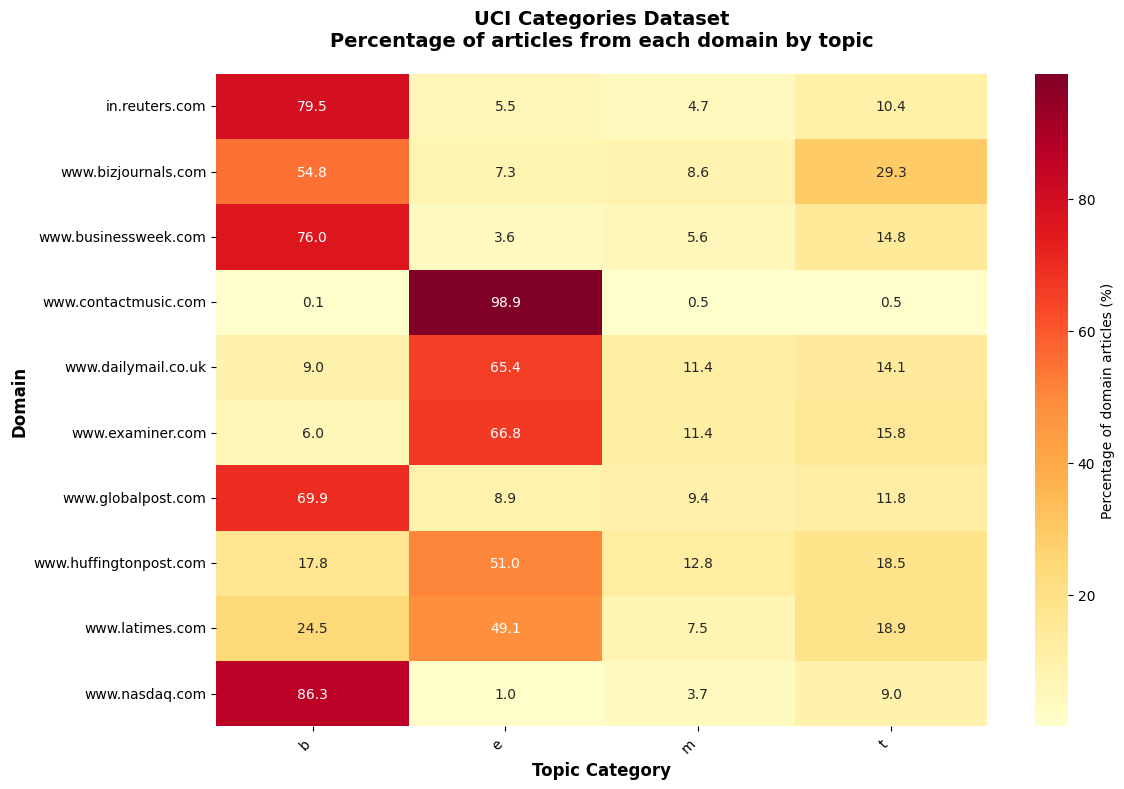

In [5]:
# Create heatmap for UCI dataset
fig_uci = create_domain_topic_heatmap(
    uci_df, 
    url_col='URL', 
    topic_col='CATEGORY',
    title='UCI Categories Dataset',
    top_domains=10,
    top_topics=10  # Will be 4 since there are only 4 categories
)

plt.show()

## Recognasumm Dataset Analysis

The Recognasumm dataset contains Brazilian news articles with Portuguese categories such as:
- Brasil, Política, Economia, Esporte, Entretenimento, etc.

In [6]:
# Load Recognasumm dataset
rec_df = con.execute('SELECT * FROM read_parquet("../data/raw/recognasumm.parquet")').df()

print(f"Recognasumm Dataset shape: {rec_df.shape}")
print("\nCategory distribution:")
print(rec_df['Categoria'].value_counts())

# Check for missing values
print("\nMissing values:")
print(rec_df[['URL', 'Categoria']].isnull().sum())

# Preview data
print("\nSample data:")
print(rec_df[['URL', 'Categoria', 'Titulo']].head())

Recognasumm Dataset shape: (135272, 11)

Category distribution:
Categoria
Política                 28746
Internacional            25849
Saúde                    23914
Ciência e Tecnologia     15135
Brasil                   13841
Economia                 12613
Esporte                   2773
Turismo e Gastronomia     2511
Entretenimento            1894
Mundo                     1569
Bem-Estar                 1551
entretenimento            1095
saúde                      712
política                   596
Governo Lula               567
Turismo e Viagem           382
Podcast                    359
Ciência e Saúde            295
Pop e Arte                 219
Meio-Ambiente              196
Esportes                   142
Jornais e Programas        120
VIVA BEM                    99
Educação                    94
Name: count, dtype: int64

Missing values:
URL          0
Categoria    0
dtype: int64

Sample data:
                                                 URL             Categoria  \
0  h


Recognasumm Dataset Summary:
Total articles analyzed: 102,908
Top 10 domains: ['www.cnnbrasil.com.br', 'g1.globo.com', 'noticias.uol.com.br', 'olhardigital.com.br', 'extra.globo.com', 'oglobo.globo.com', 'www.bbc.com', 'ultimosegundo.ig.com.br', 'saude.ig.com.br', 'economia.ig.com.br']
Top 10 topics: ['Saúde', 'Internacional', 'Política', 'Ciência e Tecnologia', 'Brasil', 'Economia', 'Esporte', 'Turismo e Gastronomia', 'Entretenimento', 'Mundo']

Domain article counts:
  www.cnnbrasil.com.br: 29,572 articles
  g1.globo.com: 25,051 articles
  noticias.uol.com.br: 13,672 articles
  olhardigital.com.br: 9,083 articles
  extra.globo.com: 8,111 articles
  oglobo.globo.com: 5,819 articles
  www.bbc.com: 5,114 articles
  ultimosegundo.ig.com.br: 3,047 articles
  saude.ig.com.br: 2,391 articles
  economia.ig.com.br: 1,048 articles


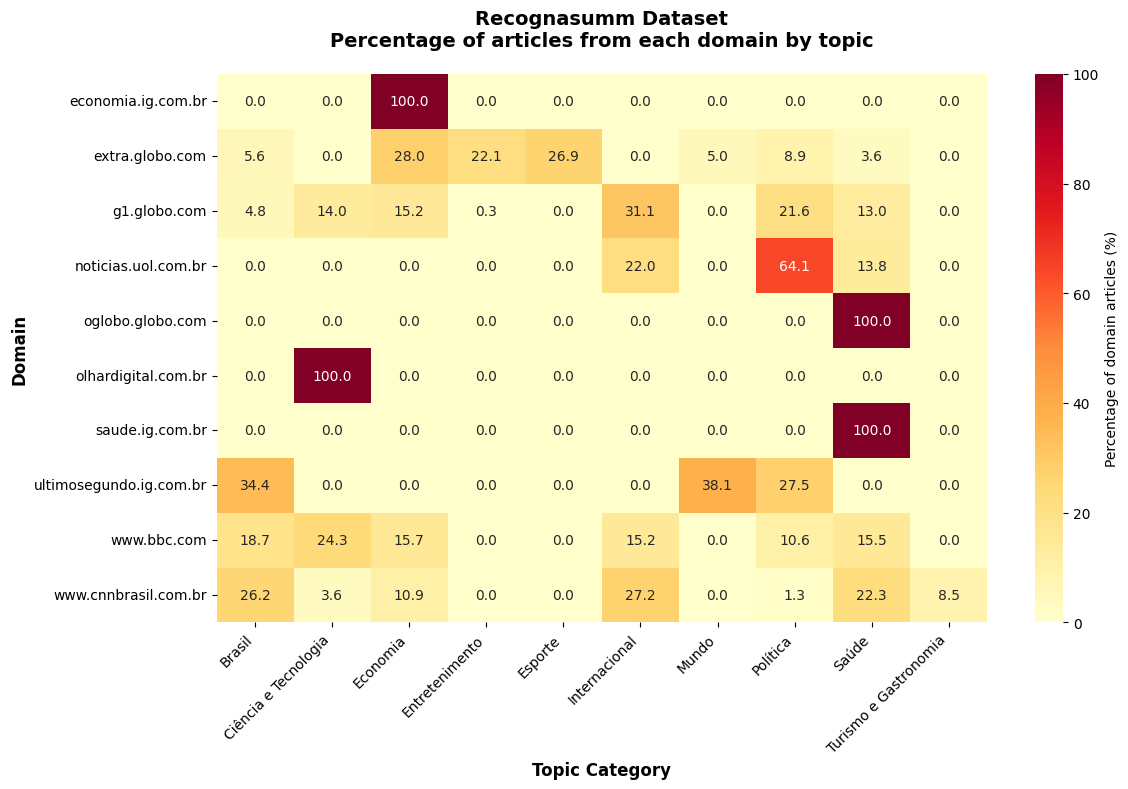

In [7]:
# Create heatmap for Recognasumm dataset
fig_rec = create_domain_topic_heatmap(
    rec_df,
    url_col='URL',
    topic_col='Categoria', 
    title='Recognasumm Dataset',
    top_domains=10,
    top_topics=10
)

plt.show()

## Detailed Domain Analysis

Let's examine the domain distributions and identify any potential skews or patterns.

In [8]:
def analyze_domain_skew(df, url_col, topic_col, dataset_name):
    """Analyze domain distribution and potential skews."""
    
    # Extract domains
    df_copy = df.copy()
    df_copy['domain'] = df_copy[url_col].apply(extract_domain)
    
    # Filter out unknown/empty domains
    df_clean = df_copy[(df_copy['domain'] != 'unknown') & (df_copy['domain'] != '')]
    
    print(f"\n{'='*50}")
    print(f"{dataset_name} Domain Analysis")
    print(f"{'='*50}")
    
    total_articles = len(df_clean)
    unique_domains = df_clean['domain'].nunique()
    
    print(f"Total articles (clean): {total_articles:,}")
    print(f"Unique domains: {unique_domains:,}")
    
    # Domain concentration
    domain_counts = df_clean['domain'].value_counts()
    top_10_share = domain_counts.head(10).sum() / total_articles * 100
    top_5_share = domain_counts.head(5).sum() / total_articles * 100
    
    print("\nDomain concentration:")
    print(f"Top 5 domains: {top_5_share:.1f}% of articles")
    print(f"Top 10 domains: {top_10_share:.1f}% of articles")
    
    print("\nTop 10 domains by article count:")
    for i, (domain, count) in enumerate(domain_counts.head(10).items(), 1):
        pct = count / total_articles * 100
        print(f"{i:2d}. {domain:<30} {count:5,} articles ({pct:4.1f}%)")
    
    # Topic distribution within top domains
    print("\nTopic diversity in top 5 domains:")
    for domain in domain_counts.head(5).index:
        domain_data = df_clean[df_clean['domain'] == domain]
        topic_dist = domain_data[topic_col].value_counts()
        entropy = -sum((p/len(domain_data)) * np.log2(p/len(domain_data)) for p in topic_dist.values if p > 0)
        print(f"{domain:<30} {len(topic_dist)} topics, entropy: {entropy:.2f}")
    
    return df_clean

# Analyze both datasets
uci_clean = analyze_domain_skew(uci_df, 'URL', 'CATEGORY', 'UCI Categories')
rec_clean = analyze_domain_skew(rec_df, 'URL', 'Categoria', 'Recognasumm')


UCI Categories Domain Analysis
Total articles (clean): 422,419
Unique domains: 11,237

Domain concentration:
Top 5 domains: 3.0% of articles
Top 10 domains: 5.3% of articles

Top 10 domains by article count:
 1. in.reuters.com                 2,877 articles ( 0.7%)
 2. www.huffingtonpost.com         2,603 articles ( 0.6%)
 3. www.businessweek.com           2,420 articles ( 0.6%)
 4. www.contactmusic.com           2,334 articles ( 0.6%)
 5. www.dailymail.co.uk            2,258 articles ( 0.5%)
 6. www.nasdaq.com                 2,228 articles ( 0.5%)
 7. www.examiner.com               2,085 articles ( 0.5%)
 8. www.globalpost.com             1,975 articles ( 0.5%)
 9. www.latimes.com                1,913 articles ( 0.5%)
10. www.bizjournals.com            1,882 articles ( 0.4%)

Topic diversity in top 5 domains:
in.reuters.com                 4 topics, entropy: 1.04
www.huffingtonpost.com         4 topics, entropy: 1.77
www.businessweek.com           4 topics, entropy: 1.12
www.contact

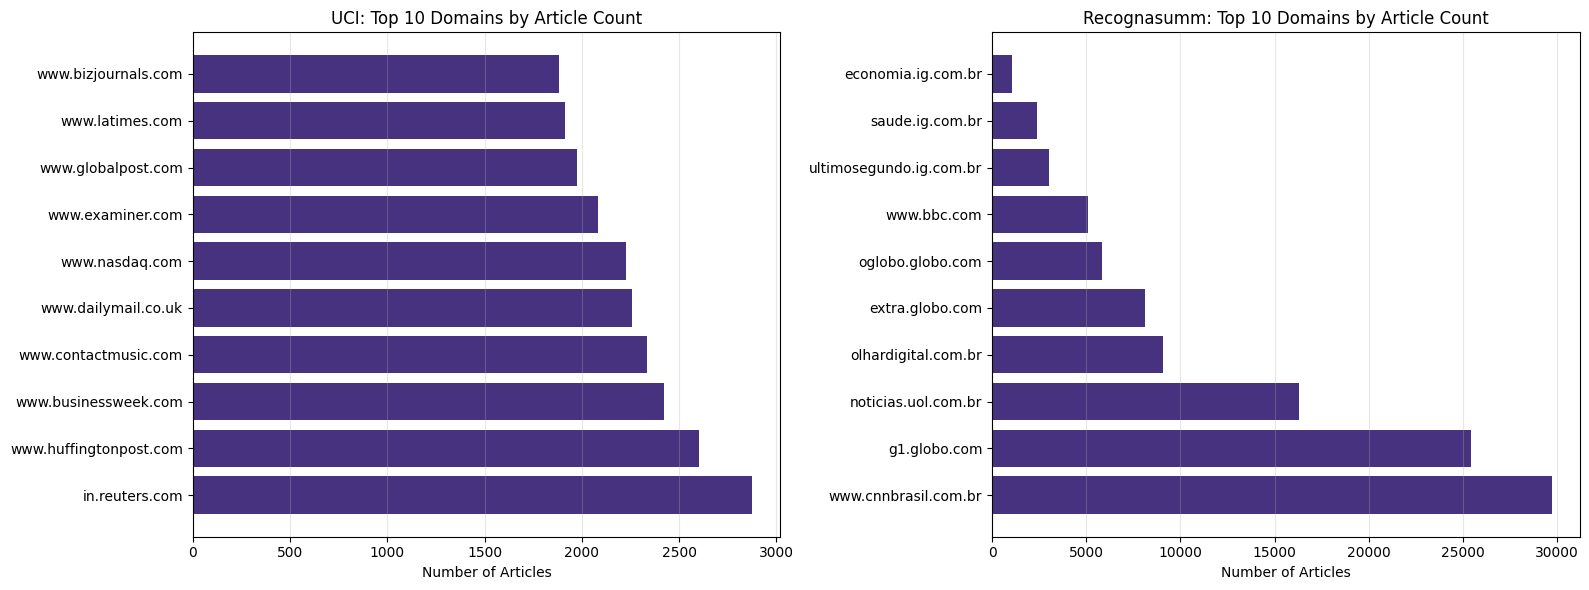


Dataset Comparison:
UCI - Articles per domain (avg): 37.6
Recognasumm - Articles per domain (avg): 6741.7


In [9]:
# Create side-by-side comparison of domain concentration
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# UCI domain distribution
uci_domain_counts = uci_clean['domain'].value_counts().head(10)
ax1.barh(range(len(uci_domain_counts)), uci_domain_counts.values)
ax1.set_yticks(range(len(uci_domain_counts)))
ax1.set_yticklabels([d[:25] + '...' if len(d) > 25 else d for d in uci_domain_counts.index])
ax1.set_xlabel('Number of Articles')
ax1.set_title('UCI: Top 10 Domains by Article Count')
ax1.grid(axis='x', alpha=0.3)

# Recognasumm domain distribution  
rec_domain_counts = rec_clean['domain'].value_counts().head(10)
ax2.barh(range(len(rec_domain_counts)), rec_domain_counts.values)
ax2.set_yticks(range(len(rec_domain_counts)))
ax2.set_yticklabels([d[:25] + '...' if len(d) > 25 else d for d in rec_domain_counts.index])
ax2.set_xlabel('Number of Articles')
ax2.set_title('Recognasumm: Top 10 Domains by Article Count')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nDataset Comparison:")
print(f"UCI - Articles per domain (avg): {len(uci_clean) / uci_clean['domain'].nunique():.1f}")
print(f"Recognasumm - Articles per domain (avg): {len(rec_clean) / rec_clean['domain'].nunique():.1f}")

## Key Insights

### Domain Concentration
- Both datasets show significant domain concentration, with the top 10 domains representing a large portion of articles
- This concentration could impact model training, as the model may become biased toward patterns from dominant domains

### Topic Distribution Patterns
- The heatmaps reveal distinct topic specialization patterns across domains
- Some domains show strong specialization (high percentage in one topic), while others are more balanced
- Understanding these patterns is crucial for:
  - Identifying potential domain bias in training data
  - Ensuring balanced representation across topics
  - Designing domain-aware evaluation strategies

### Recommendations
1. **Data Balancing**: Consider stratified sampling to ensure balanced domain representation
2. **Domain-Aware Training**: Implement domain adaptation techniques if deploying across diverse domains
3. **Evaluation Strategy**: Use domain-stratified evaluation to assess model performance across different domains